### Goal
- Identify tests that can be used to distinguish test subjects from control subjects
- Annotation Details
  - Label 0 are controls
  - Label 1 are test subjects, that may or may not have different responses.

### Preparation of Notebook

In [1]:
#Import Data Handling Packages
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score, accuracy_score

In [2]:
#Import Data
df=pd.read_csv("mock.tsv", sep="\t")

### Defined Functions

In [3]:
def plotTestDistributionByCohort(df, col, title):
    sns.catplot(data=df, x="Label", y=col, hue="Cohort")
    plt.title("Distributrion of {}".format(title))
    plt.show()    

def statAnalysisOfCohortTests(df, cohort, thresh):
    df_cohort=df.groupby("Cohort").get_group(cohort)

    names=[e for e in df_cohort.keys() if e.startswith("A")]
    names.extend([e for e in df_cohort.keys() if e.startswith("B")])

    results={}
    sig_keys=[]

    g1=df_cohort.groupby("Label").get_group(0)
    g2=df_cohort.groupby("Label").get_group(1)

    for n in names:
        l1=list(g1[n])
        l2=list(g2[n])
        
        t_statistic, p_value = stats.ttest_ind(l1, l2, equal_var=True)
        results["{}_{}".format(n,cohort)]={"mean_c":sum(l1)/len(l1),
                    "mean_s":sum(l2)/len(l1),
                    "t_stat":t_statistic,
                    "p_val":p_value,
                    "name":n,
                    "samples_c":len(l1),
                    "samples_s":len(l2),
                    "cohort":cohort}
        if p_value < thresh:
            sig_keys.append("{}_{}".format(n,cohort))
    
    return results, sig_keys

def plotHistogramsOfLabelDistributions(df, key_list, subset=True):
    for key in key_list:
        test,num,cohort=key.split("_")
        if subset:
            df_sub=df[df["Cohort"]==cohort]
            titleinfo="of Specific Cohort"
        else:
            df_sub=df
            titleinfo="of All Cohorts"
            
        plt.figure(figsize=(5,3))
        sns.histplot(data=df_sub, x="{}_{}".format(test,num), hue="Label")
        plt.title("{} Distribution {}".format(key, titleinfo))
        plt.show()

In [4]:
def plotConfusionMatrix(y, y_pred, sample, cohort, show_matrix):
    cm=confusion_matrix(y,y_pred)
    tn,fp,fn,tp=cm.ravel().tolist()
    tests={"sample":[sample], "cohort":[cohort], "tp":[tp], "fp":[fp], "fn":[fn], "tn":[tn]}
    for i in ("accuracy", "recall", "f1"):
        tests[i]=[eval("{}_score(y,y_pred)".format(i))]
    tests["precision"]=[precision_score(y, y_pred, zero_division=0)]
    if show_matrix:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidths=.5)
        plt.title('Confusion Matrix - {}\n{}'.format(sample, tests))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()   
    return tests

def classifyRegressionResults(df, cohort, label, show_matrix=True, savefile=None):
    if cohort:
        values=df[(df["Cohort"]==cohort)][["Label",label]]
    else:
        values=df[["Label",label]]
    X=np.array(list(values[label])).reshape(-1,1)
    y=np.array(list(values["Label"]))
    
    model=LogisticRegression()
    model.fit(X,y)
    y_pred=model.predict(X)

    res=plotConfusionMatrix(y,y_pred,label,cohort,show_matrix)

    if savefile:
        joblib.dump(model, savefile)
        
    return res

def plotAccuracyAndRecallforTests(df, rot=0, hue=None):
    plt.figure()
    sns.barplot(x="sample", y="accuracy", data=df, hue=hue)
    plt.title("Accuracy")
    plt.xticks(rotation=rot)
    plt.show()

    plt.figure()
    sns.barplot(x="sample", y="recall", data=df, hue=hue)
    plt.title("Recall")
    plt.xticks(rotation=rot)
    plt.show()

In [5]:
def normalizeCohortByCtrlMean(df, value, cohort, test):
    m=df[(df["Cohort"]==cohort) & (df["Label"]==0)][test].mean()
    return value-m

### Initial Data Exploration

In [6]:
#Identify data types of columns:
df.dtypes

Cohort     object
Label       int64
A_0       float64
A_1       float64
A_2       float64
           ...   
B_95      float64
B_96      float64
B_97      float64
B_98      float64
B_99      float64
Length: 202, dtype: object

In [7]:
# Cohorts and Labels represent the grouping of the data.  A's and B's represent the tests.
# Identify the groups
print ("Cohorts: {}".format(df["Cohort"].unique()))
print ("Labels: {}".format(df["Label"].unique()))

Cohorts: ['Aug' 'Jul' 'Mar']
Labels: [0 1]


In [8]:
# View some of the data
df.head()

,Cohort,Label,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,...,B_90,B_91,B_92,B_93,B_94,B_95,B_96,B_97,B_98,B_99
0,Aug,0,1.621774,1.739324,1.451617,-0.186583,2.376608,2.295373,2.722720,1.821542,...,0.864761,0.134935,0.242494,0.359284,0.003831,0.069875,0.259369,0.244837,0.554309,0.733232
1,Aug,0,2.767240,1.079509,-0.723664,1.737466,1.844370,2.059156,2.358058,1.868140,...,0.030889,0.226631,0.329706,0.826815,0.317215,0.114622,0.588142,0.668808,0.491239,0.572640
2,Aug,0,2.122517,0.713271,2.915116,1.313582,2.152386,0.885216,2.853469,0.424814,...,0.830995,0.242558,0.841052,0.958406,0.721642,0.753970,0.840054,0.979133,0.357064,0.194532
3,Aug,0,1.802962,3.129745,2.488166,0.917015,2.729987,1.810858,2.108782,0.664469,...,0.391327,0.153289,0.214403,0.113282,0.563799,0.164133,0.262977,0.387080,0.846162,0.564837
4,Aug,0,0.367035,2.749154,1.558293,1.304794,0.857214,3.152263,1.684176,1.667096,...,0.029424,0.986045,0.232829,0.953272,0.918123,0.857471,0.303726,0.404233,0.050626,0.203764


In [9]:
# Check if any values missing
missing=df.isna().sum()
missing.sum()

np.int64(0)

In [43]:
# Note there are too many values for me to grasp understanding with the table, thus, I will subset and work with the first 10 tests.
cols=10
df_subset=df.iloc[:, :cols+2]
df_subset.describe()

,Label,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.333333,0.015220,0.140165,0.021821,-0.030985,0.068323,0.037672,0.009450,0.065126,0.062814,0.167427
std,0.472984,1.464204,1.572276,1.594300,1.574234,1.599172,1.576521,1.588574,1.471894,1.475776,1.541885
min,0.000000,-3.420240,-4.041328,-4.124623,-4.132140,-3.332007,-3.490635,-4.069157,-3.223239,-4.292058,-3.160672
25%,0.000000,-1.110903,-1.108050,-1.200538,-1.072789,-1.161243,-1.138308,-1.147728,-0.929168,-1.011457,-1.005288
50%,0.000000,0.147722,0.157458,0.145486,-0.075126,0.313973,0.049026,0.038208,-0.144688,0.023032,0.149951
75%,1.000000,1.131175,1.336413,1.206092,1.100301,1.168958,1.097209,1.167444,1.161484,1.002566,1.284544
max,1.000000,3.972569,4.191416,3.771835,3.142500,3.672911,3.668122,3.496951,4.411386,4.697143,4.035225


### Data Exploration: 
- Identification of Cohort Effects

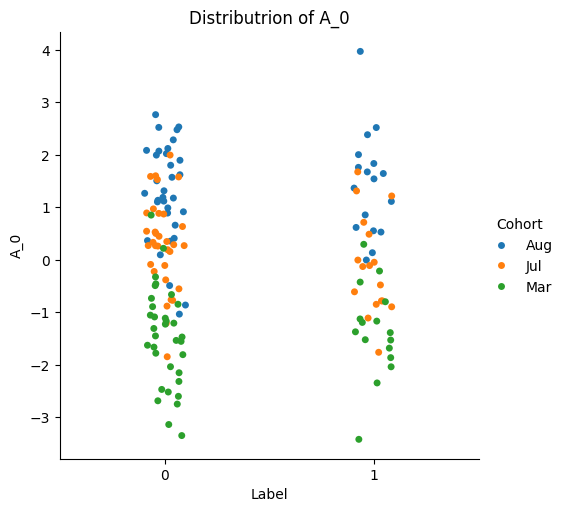

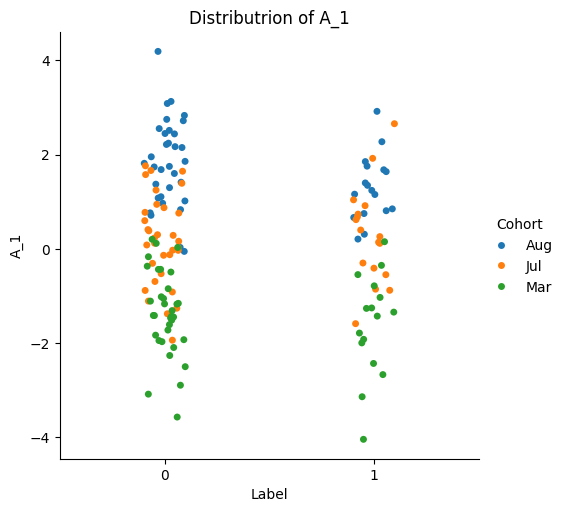

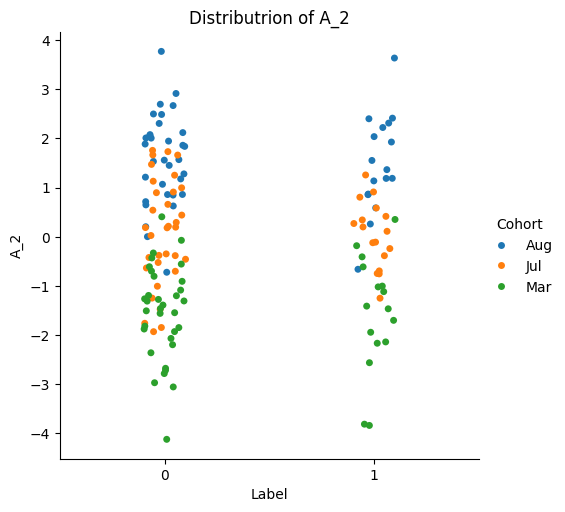

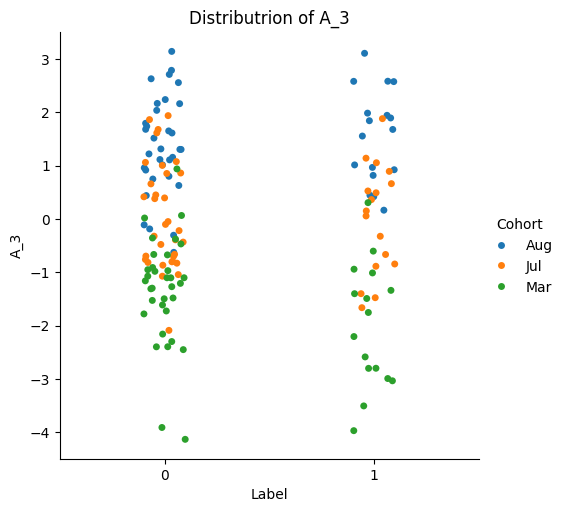

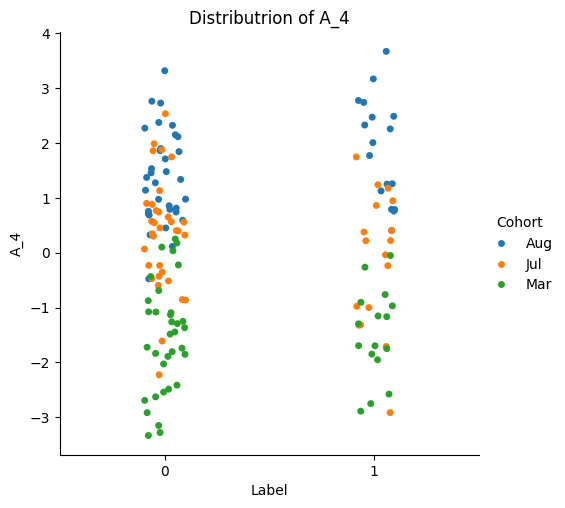

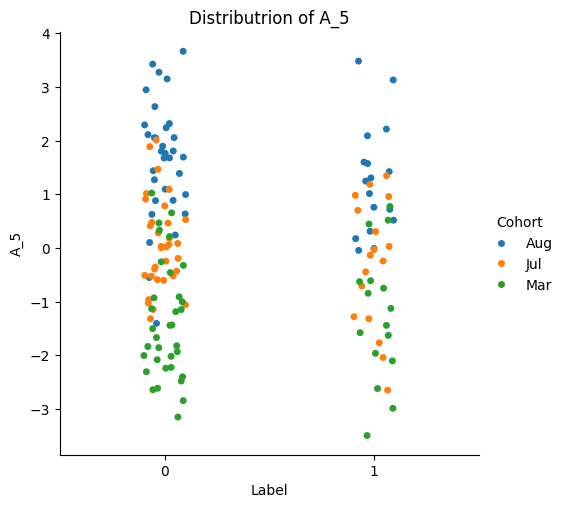

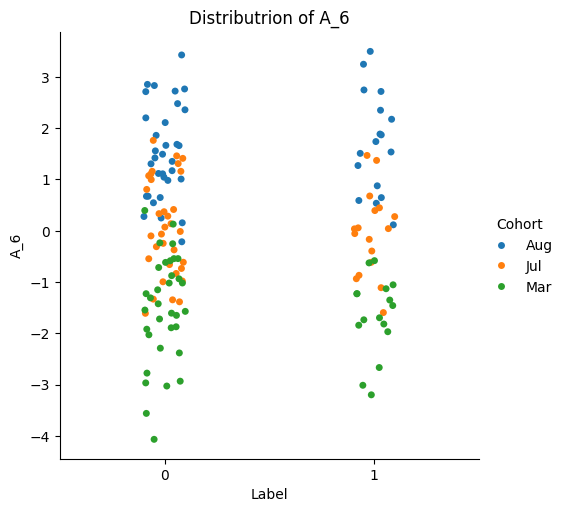

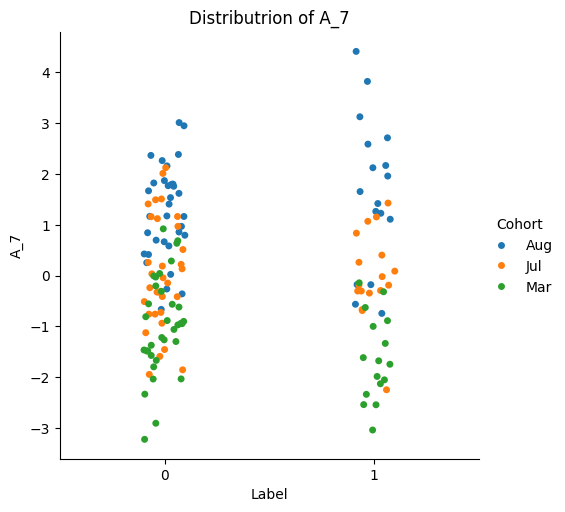

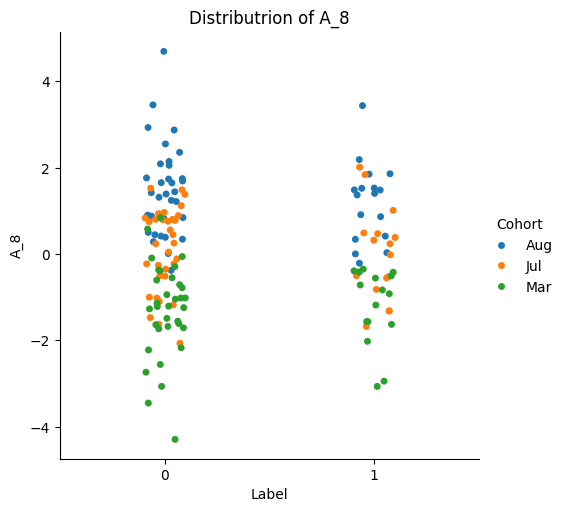

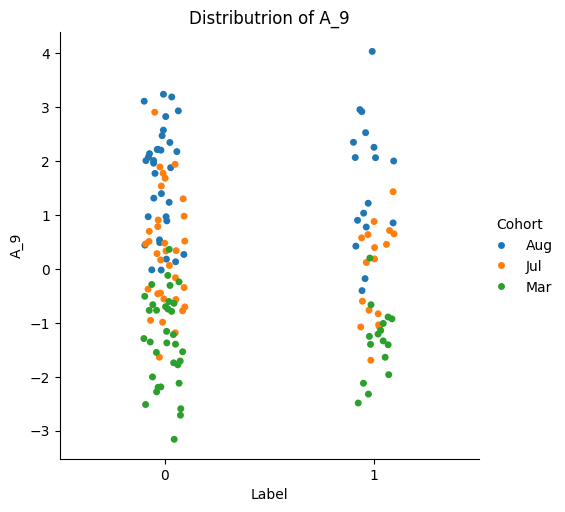

In [11]:
names=[e for e in df_subset.keys() if e.startswith("A")]
for n in names:
    plotTestDistributionByCohort(df_subset, n, n)

### Results:
 - it looks like there are cohort differences (samples have slightly different test results per cohort), 
 
### Next Steps:
 - I will focus first on understanding the march cohort to identify one or more tests that show significant differences between the two distributions

### Data Exploration
- Use of March Cohort to Identify Tests with Significant Differences 

In [12]:
results, sig_keys=statAnalysisOfCohortTests(df, "Mar", 0.05)

print ("Number of Significant Tests: {}".format(len(sig_keys)))

for key in sig_keys:
    print (results[key])

Number of Significant Tests: 15
{'mean_c': -1.332981205012813, 'mean_s': -0.9449579722965713, 't_stat': np.float64(2.103855306221537), 'p_val': np.float64(0.040655381019646906), 'name': 'A_3', 'samples_c': 34, 'samples_s': 16, 'cohort': 'Mar'}
{'mean_c': -0.9826393881198883, 'mean_s': -0.7642076159128, 't_stat': np.float64(2.2835635098753997), 'p_val': np.float64(0.02686401096065329), 'name': 'A_7', 'samples_c': 34, 'samples_s': 16, 'cohort': 'Mar'}
{'mean_c': -1.199672360234493, 'mean_s': -0.8462462980735725, 't_stat': np.float64(2.4628010076541167), 'p_val': np.float64(0.017424740245646213), 'name': 'A_18', 'samples_c': 34, 'samples_s': 16, 'cohort': 'Mar'}
{'mean_c': -1.379784400321634, 'mean_s': -1.0559708708391424, 't_stat': np.float64(3.4125618807473432), 'p_val': np.float64(0.0013156499777021563), 'name': 'A_39', 'samples_c': 34, 'samples_s': 16, 'cohort': 'Mar'}
{'mean_c': -2.695707544207242, 'mean_s': 0.08580463428218332, 't_stat': np.float64(-10.091586414286558), 'p_val': np.

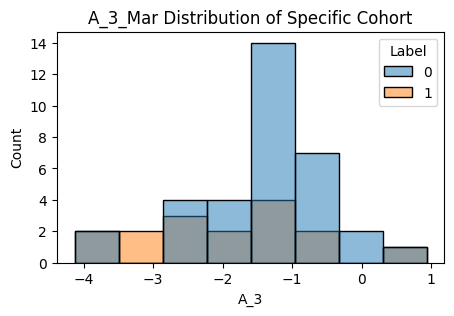

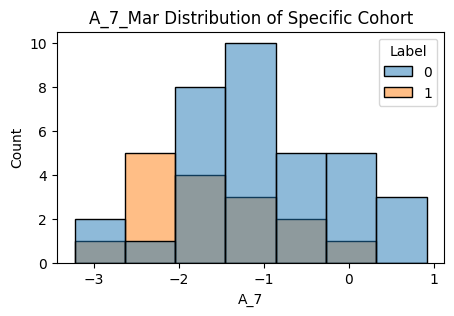

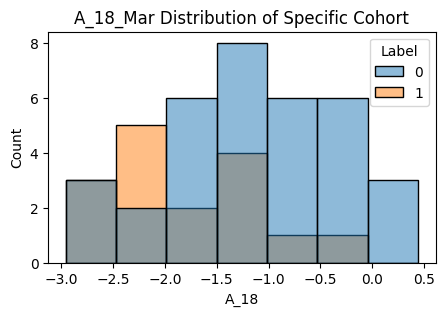

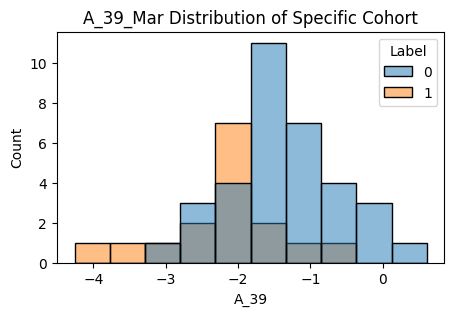

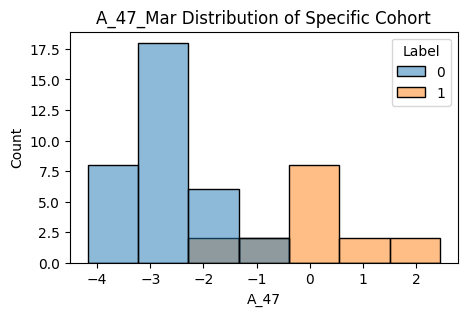

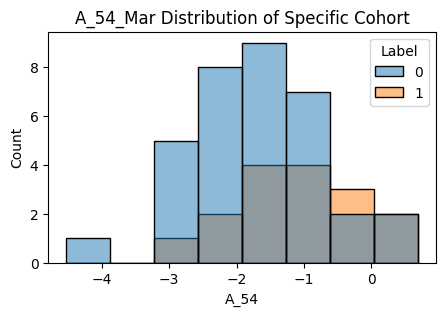

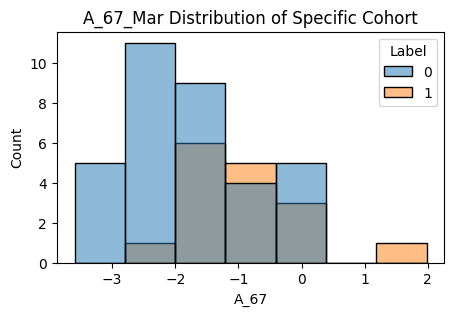

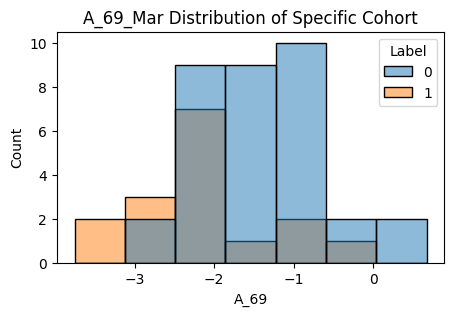

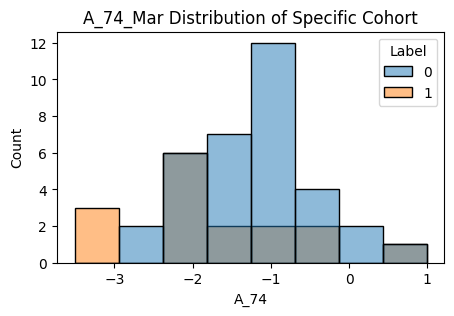

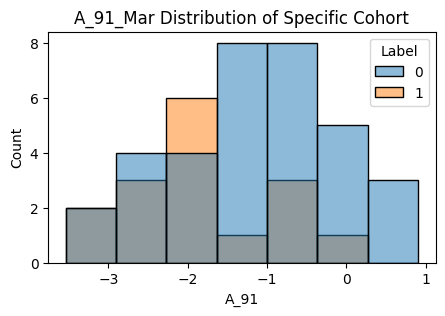

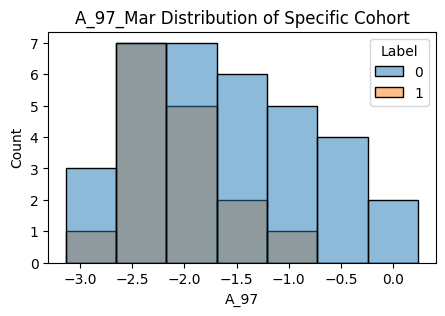

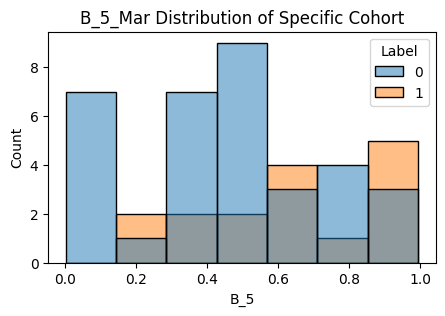

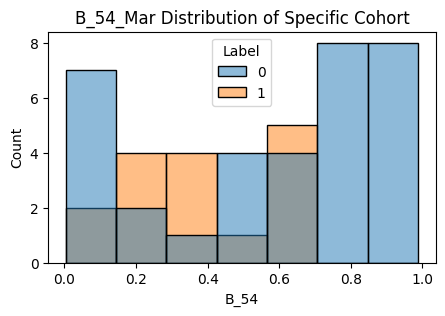

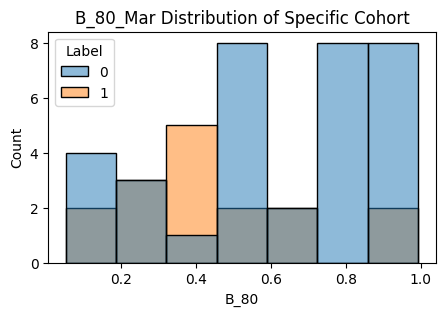

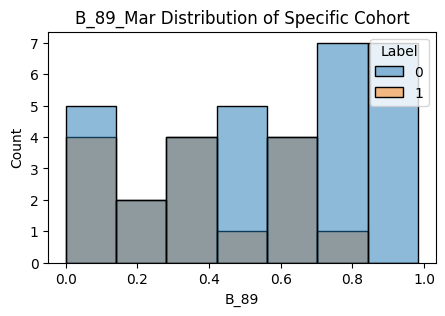

In [13]:
# plot distributions of significant tests
plotHistogramsOfLabelDistributions(df, sig_keys, True)

### Results
 - Multiple sample distributions show statistical differences.
 - Despite this, most populations are hard to visually distinguish from their plots; one distribution is clearly distinct.

### Next Steps:
 - I'll use logistic regression to determine if values from two distributions can be distinguished.
 - I'll evaluate the model using accuracy and recall.

### Data Exploration
- Logistic Regression to Identify Predictive Test

In [14]:
results_df=pd.DataFrame(columns=["sample", "cohort", "accuracy", "precision", "recall", "f1"])
for key in sig_keys:
    test,num,cohort=key.split("_")
    res=classifyRegressionResults(df, cohort, "{}_{}".format(test, num), False)
    new_df=pd.DataFrame(res)
    if results_df.empty:
        results_df=new_df.copy()
    else:
        results_df=pd.concat([results_df, new_df], ignore_index=True)

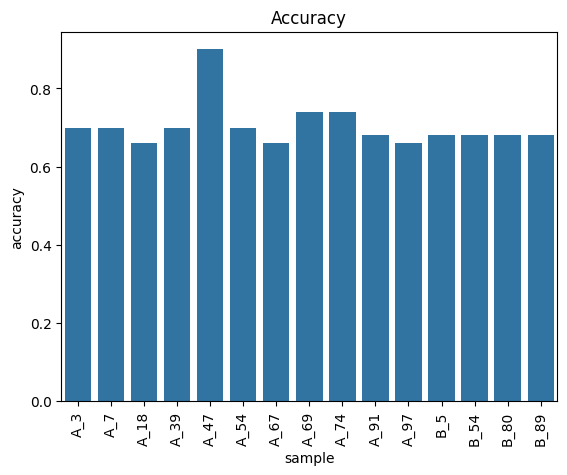

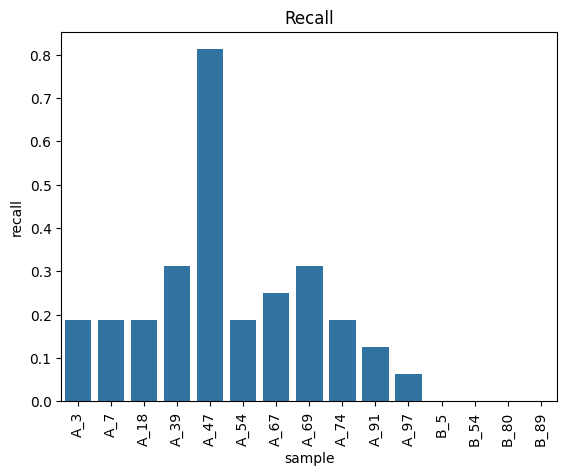

In [15]:
plotAccuracyAndRecallforTests(results_df, rot=90)

### Results:
 - A_47 is the top performer, significantly outperforming other tests in both accuracy and recall.
 - Most other tests show poor recall ( <0.5), indicating low true positive classifications.

### Next Steps:
 - Classification will be limited to A_47.
 - Assess A_47's performance across other cohorts.


### Data Exploration
- Predictive Power of A_47 test with all Cohorts

In [16]:
results47_df=pd.DataFrame(columns=["sample", "accuracy", "precision", "recall", "f1"])

for key in ["A_47_Aug", "A_47_Jul", "A_47_Mar"]:
    test,num,cohort=key.split("_")
    res=classifyRegressionResults(df, cohort, "{}_{}".format(test, num), False)
    new_df=pd.DataFrame(res)
    if results47_df.empty:
        results47_df=new_df.copy()
    else:
        results47_df=pd.concat([results47_df, new_df], ignore_index=True)

In [17]:
results47_df

,sample,cohort,tp,fp,fn,tn,accuracy,recall,f1,precision
0,A_47,Aug,15,1,2,32,0.94,0.882353,0.909091,0.937500
1,A_47,Jul,16,0,1,33,0.98,0.941176,0.969697,1.000000
2,A_47,Mar,13,2,3,32,0.90,0.812500,0.838710,0.866667


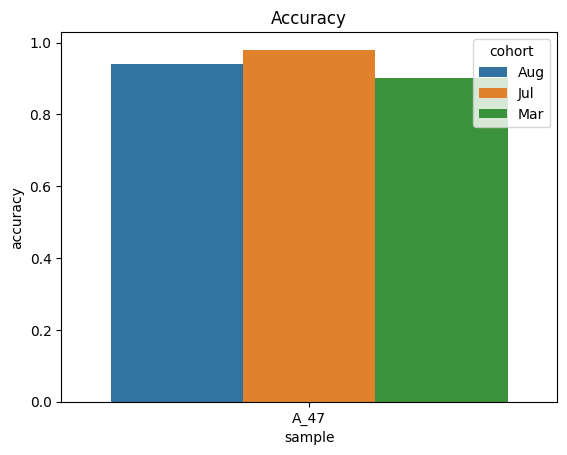

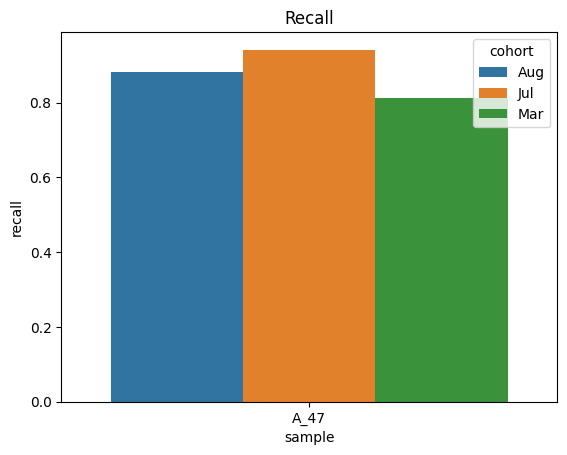

In [18]:
plotAccuracyAndRecallforTests(results47_df, hue="cohort")

### Results:
- A_47 is statistically significant and capable of predicting classifications across all existing cohorts.

### Next Steps:
- Logistic regression with numeric cohort conversion will not be performed
  - It is not considered the most useful approach, as will not be able to predict new cohorts
- Logistic regression after normalizing test data to the mean control data
  - It will allow new cohorts, but will be expensive as requires a large control data set to be tested every time.
- Logistic regresssion after identifying an internal normalization factor.
  - May be unachievable, but will look to see effect on classification.


### Model Building (1)
- Normalization to Control Test Data

In [19]:
df_47=df[["Cohort", "Label", "A_47"]].copy()

In [20]:
df_47["A_47_adj"]=df_47.apply(lambda row: normalizeCohortByCtrlMean(df_47, row["A_47"], row["Cohort"], "A_47"), axis=1)
df_47

,Cohort,Label,A_47,A_47_adj
0,Aug,0,-0.208579,-0.154442
1,Aug,0,-0.302183,-0.248046
2,Aug,0,0.154894,0.209031
3,Aug,0,0.079102,0.133240
4,Aug,0,-0.627940,-0.573802
...,...,...,...,...
145,Mar,1,0.512558,3.208265
146,Mar,1,-0.389370,2.306337
147,Mar,1,-1.611096,1.084611
148,Mar,1,0.512547,3.208254


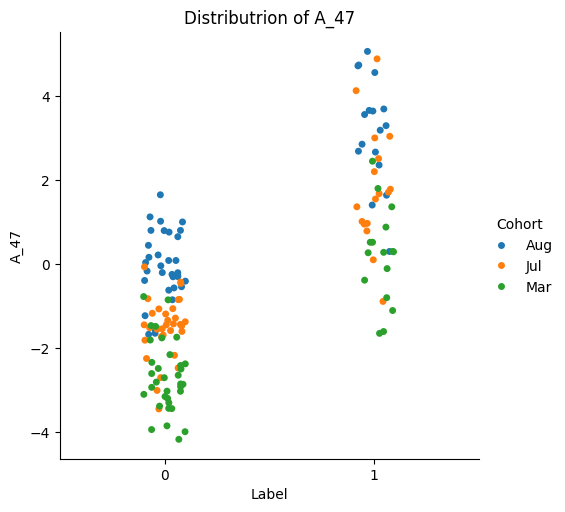

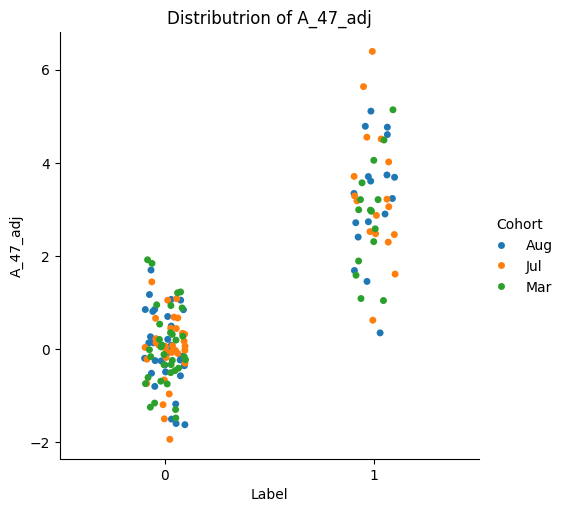

In [21]:
plotTestDistributionByCohort(df_47, "A_47", "A_47")
plotTestDistributionByCohort(df_47, "A_47_adj", "A_47_adj")

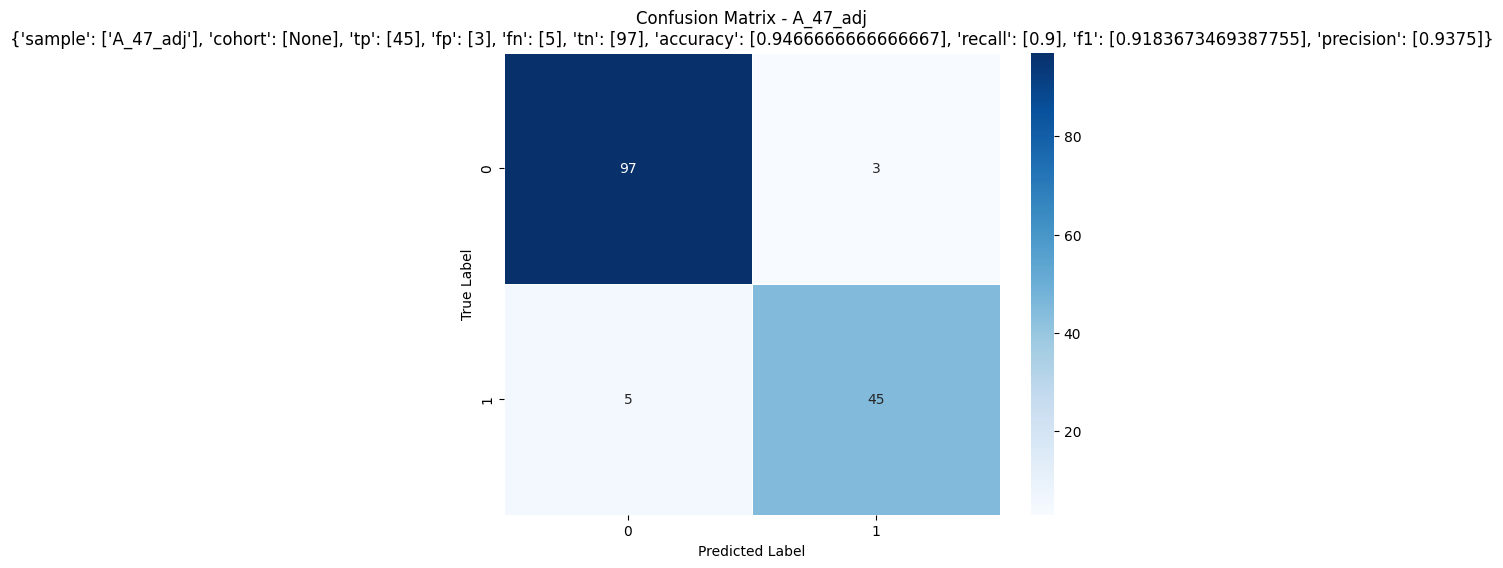

In [22]:
adj_res=classifyRegressionResults(df_47, None, "A_47_adj", show_matrix=True, savefile="model.A47LogisticRegression.normtoctrl.joblib")

In [23]:
new_df=pd.DataFrame(adj_res)
results47_df=pd.concat([results47_df, new_df], ignore_index=True)
results47_df["sample"]="A_47"
results47_df["cohort"]=np.where(results47_df["cohort"].isnull(), "Adj", results47_df["cohort"])
results47_df

,sample,cohort,tp,fp,fn,tn,accuracy,recall,f1,precision
0,A_47,Aug,15,1,2,32,0.940000,0.882353,0.909091,0.937500
1,A_47,Jul,16,0,1,33,0.980000,0.941176,0.969697,1.000000
2,A_47,Mar,13,2,3,32,0.900000,0.812500,0.838710,0.866667
3,A_47,Adj,45,3,5,97,0.946667,0.900000,0.918367,0.937500


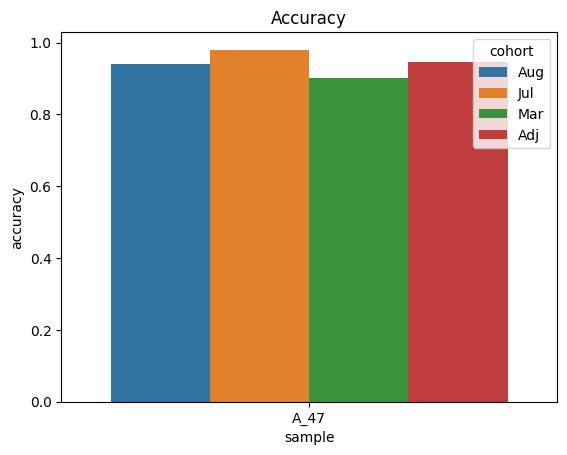

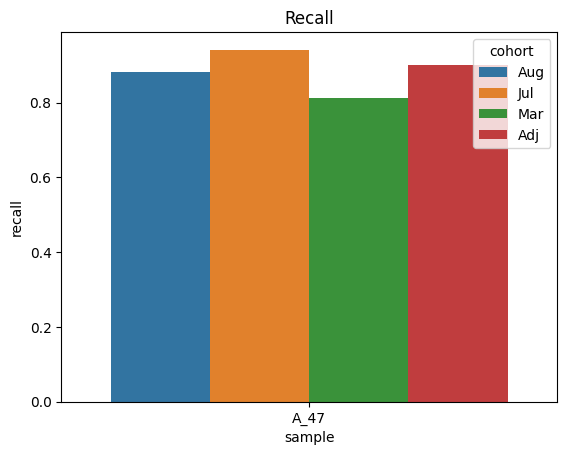

In [24]:
plotAccuracyAndRecallforTests(results47_df, hue="cohort")

### Results
 - Model performs very well with accuracy >94% and recall >90%
 - Model Saved as "model.A47LogisticRegression.normtoctrl.joblib"
 - Must run "normalizeCohortByCtrlMean on test and control samples before predicting model

### Data Exploration
- Identify a potential Internal Normalization Factor
  - Normalization factor will have consistant difference between A_47 control and another test
  - This is sort of asking is one test dependant on another

In [25]:
def diff(a,b):
    return a-b

col_list=[e for e in df.keys() if e not in ["Cohort", "Label", "A_47"]]

df_diff = pd.concat([df, df[col_list].subtract(df['A_47'], axis=0).add_prefix('diff_')], axis=1)


In [26]:
df_control=df_diff[df_diff["Label"]==0]

In [27]:
col_list=[e for e in df_control.keys() if e.startswith("diff")]
df_control[col_list].apply(lambda x: max(x)-min(x)).min()

np.float64(4.6849741015460005)

In [28]:
df_long=pd.melt(df_diff,
                  id_vars=['Label', "Cohort", "A_47"],  # Columns to keep as identifier variables
                  value_vars=col_list[:10], # Columns to unpivot
                  var_name='Test',  # Name for the new column containing original column headers
                  value_name='Result') # Name for the new column containing the values


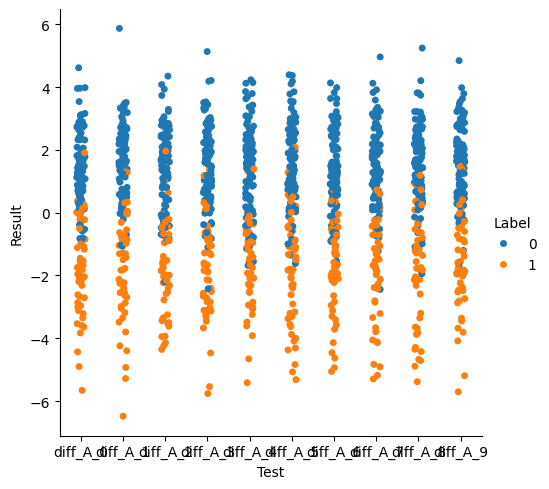

In [29]:
sns.catplot(df_long, x="Test", y="Result", hue="Label")

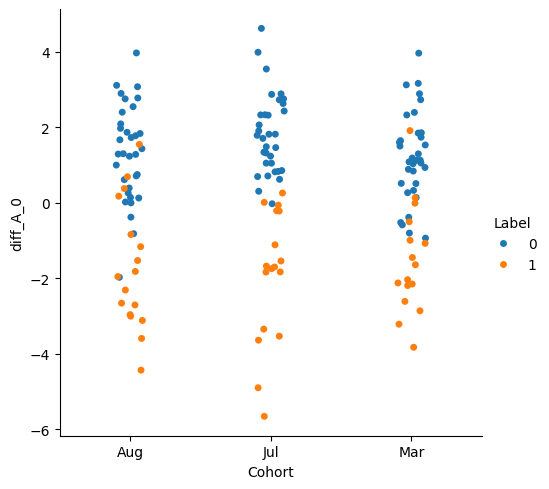

In [30]:
sns.catplot(df_diff, x="Cohort", hue="Label", y="diff_A_0" )

### Results:
- Internal normalization looks like it may be possible.  There is a difference in distribution (determined by eye in a number of the tests, that seem to categorize the two labels.

### Next Steps:
- Perform linear regression to determine which tests are decent at distinguishing the two labels.
- Combine multiple tests to create a more robust test.

### Data Exploration:
- Logistic regression of Differential Values to determine classification ability.

In [31]:
results_diff=pd.DataFrame()
for t in col_list:
    res=classifyRegressionResults(df_diff, cohort=None, label=t, show_matrix=False, savefile=None)
    new_df=pd.DataFrame(res)
    if results_diff.empty:
        results_diff=new_df.copy()
    else:
        results_diff=pd.concat([results_diff, new_df], ignore_index=True)

In [32]:
results_diff

,sample,cohort,tp,fp,fn,tn,accuracy,recall,f1,precision
0,diff_A_0,None,38,6,12,94,0.880000,0.76,0.808511,0.863636
1,diff_A_1,None,40,6,10,94,0.893333,0.80,0.833333,0.869565
2,diff_A_2,None,38,6,12,94,0.880000,0.76,0.808511,0.863636
3,diff_A_3,None,42,6,8,94,0.906667,0.84,0.857143,0.875000
4,diff_A_4,None,42,7,8,93,0.900000,0.84,0.848485,0.857143
...,...,...,...,...,...,...,...,...,...,...
194,diff_B_95,None,35,6,15,94,0.860000,0.70,0.769231,0.853659
195,diff_B_96,None,36,9,14,91,0.846667,0.72,0.757895,0.800000
196,diff_B_97,None,37,9,13,91,0.853333,0.74,0.770833,0.804348
197,diff_B_98,None,35,9,15,91,0.840000,0.70,0.744681,0.795455


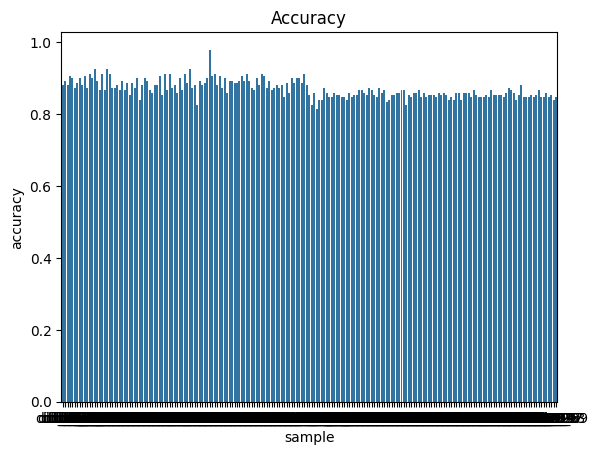

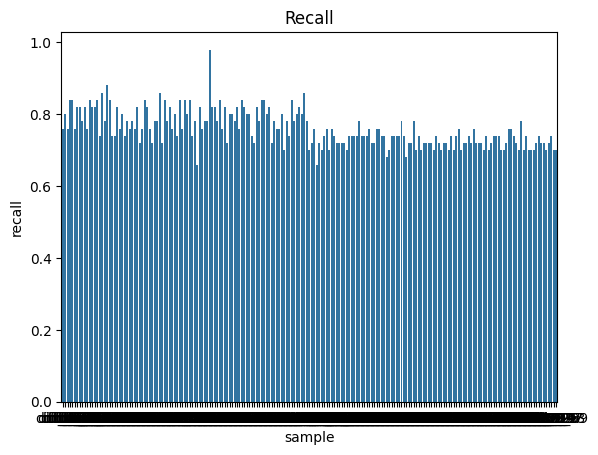

In [33]:
plotAccuracyAndRecallforTests(results_diff)

In [34]:
results_diff[(results_diff["accuracy"]>0.9) & (results_diff["recall"]>0.9)]

,sample,cohort,tp,fp,fn,tn,accuracy,recall,f1,precision
59,diff_A_60,None,49,2,1,98,0.98,0.98,0.970297,0.960784


### Results:
- diff_A_60 has a extremely high accuracy and recall.  This would be a great candidate for internal normalalization.

### Next Steps:
- make and save model for internal normalization wiht A_60.

### Model Building:
- create model for internal normalization with A_60

In [35]:
df_subset=df[["Label", "A_47", "A_60"]].copy()
df_subset["Test_Diff"]=df_subset["A_60"]-df_subset["A_47"]
df_subset

,Label,A_47,A_60,Test_Diff
0,0,-0.208579,0.704230,0.912809
1,0,-0.302183,-0.978146,-0.675962
2,0,0.154894,1.154145,0.999251
3,0,0.079102,-0.907471,-0.986573
4,0,-0.627940,-2.281187,-1.653248
...,...,...,...,...
145,1,0.512558,-3.273189,-3.785746
146,1,-0.389370,-2.915589,-2.526219
147,1,-1.611096,-3.545758,-1.934661
148,1,0.512547,-3.032723,-3.545270


In [37]:
X=np.array(list(df_subset["Test_Diff"])).reshape(-1,1)
y=np.array(list(df_subset["Label"]))

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

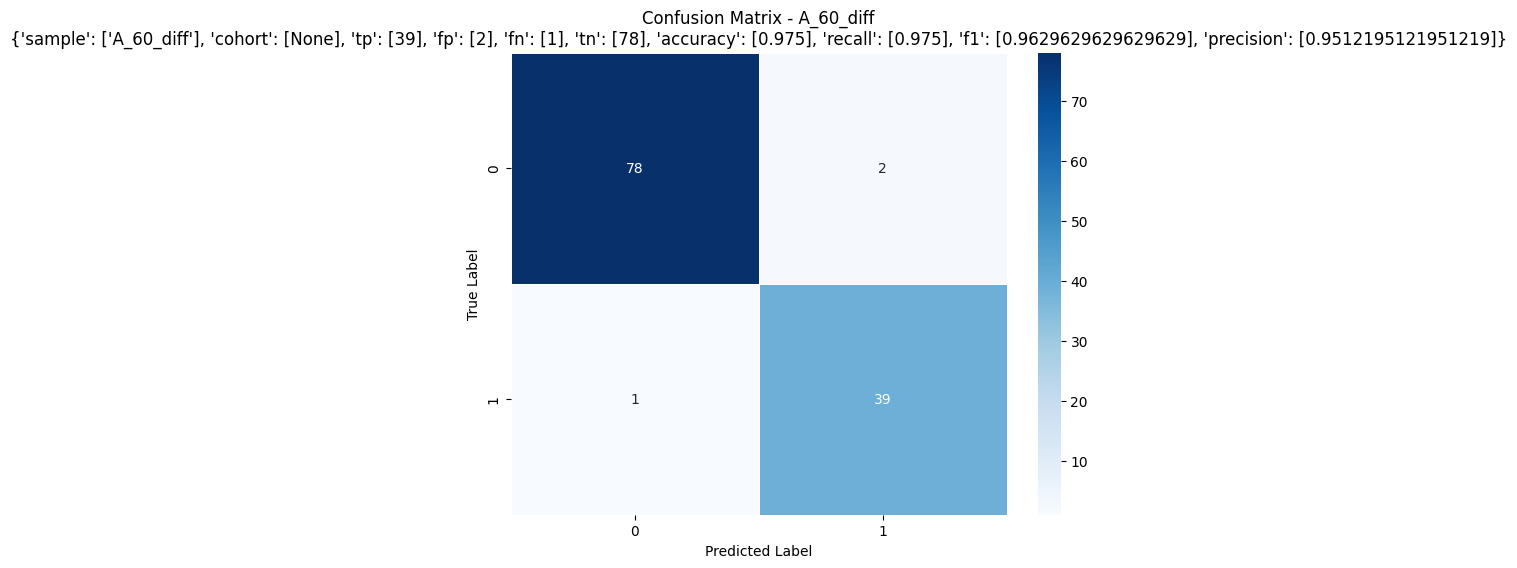

In [38]:
savefile="model.A47LogisticRegression.normtoA60.joblib"
model=LogisticRegression()
model.fit(X_train,y_train)
y_train_pred=model.predict(X_train)

res=plotConfusionMatrix(y_train,y_train_pred,"A_60_diff",cohort=None,show_matrix=True)

if savefile:
    joblib.dump(model, savefile)

In [39]:
new_df=pd.DataFrame(res)
new_df["cohort"]=np.where(new_df["cohort"].isnull(), "train", new_df["cohort"])
results47_df=pd.concat([results47_df, new_df], ignore_index=True)
results47_df

,sample,cohort,tp,fp,fn,tn,accuracy,recall,f1,precision
0,A_47,Aug,15,1,2,32,0.940000,0.882353,0.909091,0.937500
1,A_47,Jul,16,0,1,33,0.980000,0.941176,0.969697,1.000000
2,A_47,Mar,13,2,3,32,0.900000,0.812500,0.838710,0.866667
3,A_47,Adj,45,3,5,97,0.946667,0.900000,0.918367,0.937500
4,A_60_diff,train,39,2,1,78,0.975000,0.975000,0.962963,0.951220


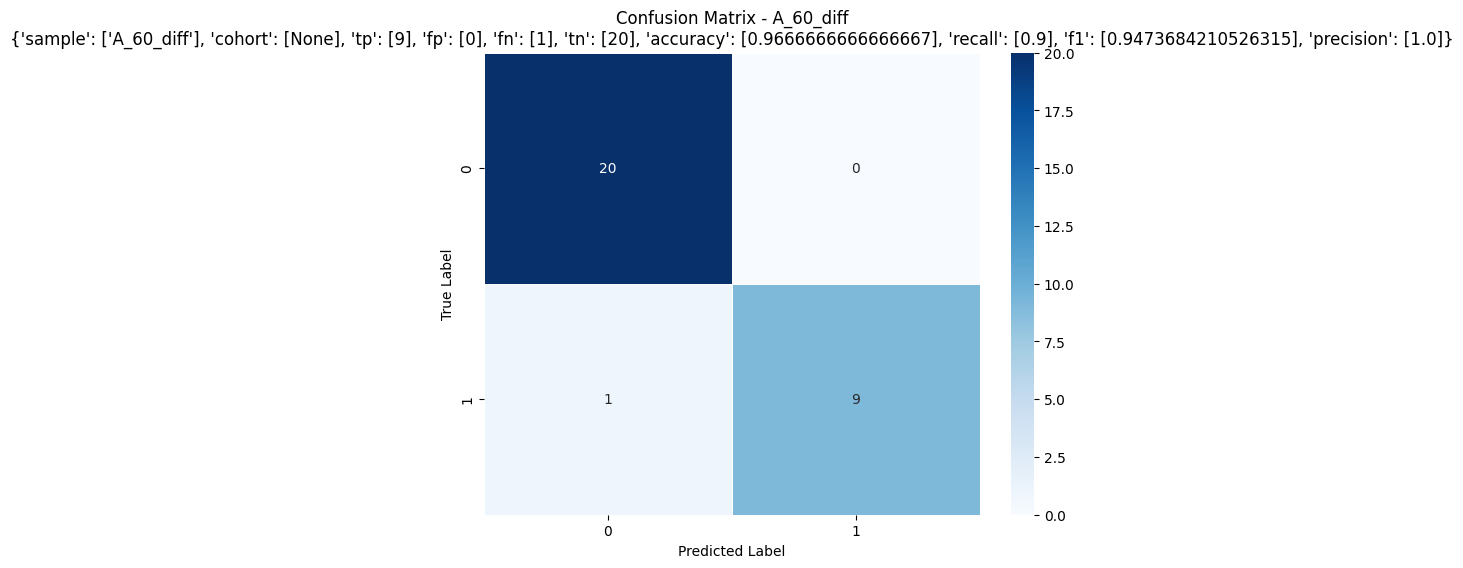

In [40]:
y_test_pred=model.predict(X_test)
res=plotConfusionMatrix(y_test,y_test_pred,"A_60_diff",cohort=None,show_matrix=True)

In [41]:
new_df=pd.DataFrame(res)
new_df["cohort"]=np.where(new_df["cohort"].isnull(), "test", new_df["cohort"])
results47_df=pd.concat([results47_df, new_df], ignore_index=True)
results47_df

,sample,cohort,tp,fp,fn,tn,accuracy,recall,f1,precision
0,A_47,Aug,15,1,2,32,0.940000,0.882353,0.909091,0.937500
1,A_47,Jul,16,0,1,33,0.980000,0.941176,0.969697,1.000000
2,A_47,Mar,13,2,3,32,0.900000,0.812500,0.838710,0.866667
3,A_47,Adj,45,3,5,97,0.946667,0.900000,0.918367,0.937500
4,A_60_diff,train,39,2,1,78,0.975000,0.975000,0.962963,0.951220
5,A_60_diff,test,9,0,1,20,0.966667,0.900000,0.947368,1.000000


### Results
- Model performs very well with accuracy >96% and recall >90%
- Model Saved as "model.A47LogisticRegression.normtoA60.joblib"
- Must subtract A_47 test results from A_60 test results

### Next Steps:
- create a function that takes A_47 and A_60 test results to predict wether it is a control or test sample

### Final Functions

In [81]:
def predictLabelFromA47andA60Tests(model, a47, a60):
    '''
    functions takes the following arguments:
    model - an sklearn.linear_model._logistic.LogisticRegression object
    A47 - a float value for the A_47 test
    A60 - a float value for the A_60 test
    '''
    d=np.array([a60-a47]).reshape(-1,1)
    return model.predict(d)

In [92]:
model=joblib.load("model.A47LogisticRegression.normtoA60.joblib")
test_df=df.sample(n=10, random_state=42)
test_df=test_df.reset_index(names=['SampleNum'])

,SampleNum,Cohort,Label,A_0,A_1,A_2,A_3,A_4,A_5,A_6,...,B_90,B_91,B_92,B_93,B_94,B_95,B_96,B_97,B_98,B_99
0,73,Jul,0,0.893847,0.759577,0.658341,-0.803248,-0.470075,0.466688,1.410904,...,0.436334,0.977799,0.502924,0.770144,0.709881,0.131999,0.394691,0.250363,0.530367,0.024414
1,18,Aug,0,2.072705,-0.052903,1.946017,1.015890,1.901251,1.681270,1.303985,...,0.684479,0.490600,0.245527,0.501767,0.113261,0.627670,0.460532,0.565831,0.226599,0.555178
2,118,Mar,0,-2.685836,-1.607801,-2.070751,-1.103252,-2.486754,-1.499627,-0.254864,...,0.920434,0.786503,0.695767,0.327824,0.211191,0.037149,0.681570,0.396324,0.689383,0.202360
3,78,Jul,0,0.333689,-0.123430,-0.459142,-0.796793,1.749806,-0.522162,1.157860,...,0.191954,0.227946,0.001550,0.991042,0.363603,0.232640,0.069667,0.079306,0.244828,0.979091
4,76,Jul,0,1.580112,0.287490,0.994969,1.075739,0.566292,0.530815,0.283853,...,0.105589,0.229027,0.329251,0.601565,0.810292,0.098875,0.714837,0.354004,0.187831,0.186685
5,31,Aug,0,1.505915,2.720138,1.066853,0.438997,0.327592,2.057185,0.646814,...,0.549493,0.532434,0.226719,0.601555,0.055975,0.942040,0.360106,0.245052,0.951397,0.275635
6,64,Jul,0,0.193189,0.121382,-0.380375,-0.391151,0.742003,0.183834,-0.246888,...,0.652092,0.638705,0.213144,0.545711,0.030399,0.746342,0.607408,0.589728,0.464680,0.505074
7,141,Mar,1,-1.167489,-0.349322,-1.467912,-2.992117,-1.695466,-1.122737,-3.014879,...,0.831274,0.487465,0.080697,0.871384,0.155254,0.265695,0.671430,0.000122,0.452064,0.398753
8,68,Jul,0,0.971105,0.300634,1.664090,-2.088670,-0.352680,-0.242782,-0.736756,...,0.531903,0.481176,0.864770,0.953961,0.101326,0.399422,0.635180,0.902507,0.961421,0.769131
9,82,Jul,0,1.530827,0.775785,-0.385331,1.060866,0.768358,0.787705,-1.611490,...,0.854693,0.851937,0.820273,0.162275,0.300576,0.496375,0.024759,0.436891,0.094150,0.794348


In [96]:
# Run the Model
# Requires a dataframe with the columns: SampleNum, A_47, and A_60
# Requires a Logistic Regression Model loaded

test_df["Prediction"]=predictLabelFromA47andA60Tests(model, test_df["A_47"], test_df["A_60"])
test_df[["SampleNum", "Prediction"]]

,SampleNum,Prediction
0,73,0
1,18,0
2,118,0
3,78,0
4,76,0
5,31,0
6,64,0
7,141,1
8,68,0
9,82,0


### Results:
- A model was able to be generated using an intrasample normalization factor (i.e. one of the other tests to normalize the batch effect).
- This model worked as good/better than using a control group for normalizing the batch effect.
- A function (predictLabelFromA47andA60Tests) taking the model and specific values (or a list of values) for A_47 and A_tests was provided.